[Solution of the Poisson equation within the domain \[0,1\]](https://github.com/nithinadidela/poisson-eq-FDM/blob/master/Thomas-TDMA.py)

## EXACT SOLUTION

In [2]:
import numpy as np
import math as m
import scipy.misc as sm
from numba import jit, f8

@jit(f8(f8, f8, f8, f8))
def P0(z, Bi, δ, Gr):
    p1 = -2*Bi*(δ**2)*(z**4)/((1+Bi)*m.factorial(4))
    p2 = 2*(δ**2)*(z**3)/((1+Bi)*m.factorial(3))
    p3 = ((δ**2)*Bi*(Bi+3)-3*Bi*(Bi+1))*(z**2)/(12*((Bi+1)**2))
    p4 = ((3*(Bi+1)-(δ**2)*(Bi+3))/(6*((Bi+1)**2)) - (δ**2)*(4*Bi+15)/(60*(1+Bi)))*z
    return p1 + p2 + p3 + p4 + 1

@jit(f8(f8, f8, f8, f8))
def P11(z, Bi, δ, Gr):
    p1 = Bi*(z**2)/((1+Bi)*m.factorial(2))
    p2 = -z/(1+Bi)
    return p1+p2

@jit(f8(f8, f8, f8, f8))
def T0(z, Bi, δ, Gr):
    t1 = -(Bi*(δ**2)*(z**3))/((1+Bi)*m.factorial(3))
    t2 = ((δ**2)*(z**2))/((1+Bi)*m.factorial(2))
    t3 = ((δ**2)*Bi*(Bi+3)-3*Bi*(Bi+1))*z/(6*((Bi+1)**2))
    t4 = (3*(Bi+1)-(δ**2)*(Bi+3))/(6*((Bi+1)**2)) 
    return t1 + t2 + t3 + t4

def dP0(z, Bi, δ, Gr):
    return sm.derivative(lambda z: P0(z, Bi, δ, Gr), z, dx=0.001)

In [3]:
import matplotlib.pyplot as plt
from numba import jit, f8

class Parameters:
    def __init__(self, Bi, δ, Gr):
        self.Bi = Bi
        self.δ = δ
        self.Gr = Gr

def PrintExactSolution(exact_solution, parameters):
    l=1.0			     # length of the domain
    n=100			     # number of mesh divisions (for first question)	
    del_z=l/(n-1)		 # mesh size

    z_values = np.zeros(n)
    e_values = np.zeros(n)

    z_values[0] = -1
    e_values[0] = exact_solution(z_values[0], parameters.Bi, parameters.δ, parameters.Gr)

    for i in range(1, len(z_values)):
        z_values[i]=z_values[i-1]+del_z
        e_values[i]=exact_solution(z_values[i], parameters.Bi, parameters.δ, parameters.Gr)

    plt.plot(z_values, e_values, color='blue', markerfacecolor='blue', linestyle='dashed')
    plt.title('Exact solution (Gr={})'.format(parameters.Gr))
    plt.xlabel('Domain')
    plt.ylabel('Exact Solution')
    plt.show()

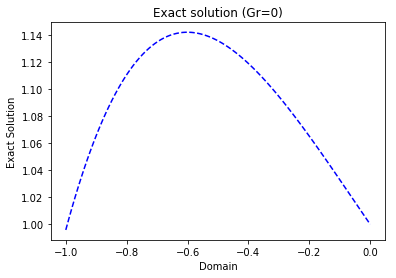

In [4]:
PrintExactSolution(P0, Parameters(Bi=2, δ=1.5, Gr=0))

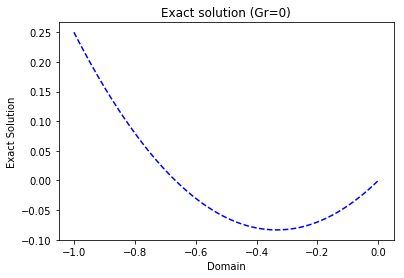

In [5]:
PrintExactSolution(P11, Parameters(Bi=-3, δ=0, Gr=0))

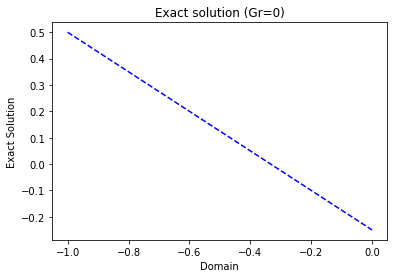

In [6]:
PrintExactSolution(T0, Parameters(Bi=-3, δ=0.01, Gr=0))

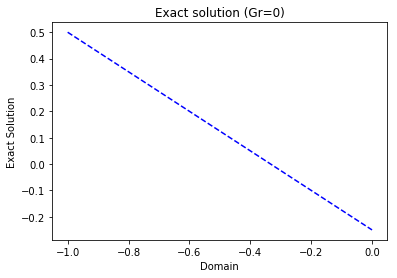

In [7]:
PrintExactSolution(dP0, Parameters(Bi=-3, δ=0.01, Gr=0))

## NUMERICAL SOLUTION

In [8]:
import numba as nb
import math as mt

@nb.jit(f8(nb.f8, nb.f8, nb.f8, nb.f8, nb.f8))
def CalcInitialConditions(z, Bi, δ, Gr, ω):
    C1 = (dP0(z, Bi, δ, Gr) - T0(z, Bi, δ, Gr)) / (δ**2)

    a = 1
    b = -Gr*ω
    c = -1
    D = ((b**2)-4*a*c)/2*a

    k1 = (-b + mt.sqrt(D))/2*a
    k2 = (-b - mt.sqrt(D))/2*a

    λ1 = mt.exp(-k2)/(mt.exp(-k2) - mt.exp(-k1))
    λ2 = -mt.exp(-k1)/(mt.exp(-k2) - mt.exp(-k1))

    return λ1*mt.exp(k1*z) - λ2*mt.exp(k2*z)

In [40]:
@nb.jit(nb.types.Tuple((nb.f8[:], nb.f8[:]))(nb.f8, nb.f8, nb.f8))
def CalcFirstEquation(δ, Bi, Gr):   
    l=1.0
    n=100
    #h=l/(n-1)

    h=δ/n
    τ = 1e-4
    ε = 1e-5

    z=np.zeros(n)
    α = np.zeros(n)
    β = np.zeros(n)
    ω = np.zeros(n)

    z[0] = -1
    ω[0] = CalcInitialConditions(z[0], Bi, δ, Gr, 0.5)

    α[0] = 0
    β[0] = 0

    for i in range(1, n-1):
        z[i]=i*h + z[0]

        ω_t1 = ω[i-1]
        ω_t2 = 0

        while True:
            # IV
            #a = δ**2
            #b = -Gr*(δ**2)*ω_t1
            #c = 0
            #f = dP0(z[i], Bi, δ) - T0(z[i], Bi, δ) - ω_t1/τ
 
            #A = 2*a+b*h
            #B = -(4*a*f-2*c*(h**2))
            #C = 2*a-b*h
            #F = 2*(h**2)*f

            # K
            #A = τ*((δ**2)/(h**2) - (Gr*(δ**2)/(2*h))*ω_t1)
            #B = 1 + 2*τ*(δ**2)/(h**2)
            #C = τ*((δ**2)/(h**2) + (Gr*(δ**2)/(2*h))*ω_t1)
            #F = - ω_t1 + τ*(dP0(z[i], Bi, δ, Gr) - T0(z[i], Bi, δ, Gr))

            #SS
            #A = -τ*(δ**2)*(2+Gr*ω_t1*h)
            #B = 2*(h**2 + 2*(δ**2)*τ)
            #C = -τ*(δ**2)*(2 - Gr*ω_t1*h)
            #F = 2*(h**2)*τ*(dP0(z[i], Bi, δ, Gr) - T0(z[i], Bi, δ, Gr)) - 2*(h**2)*ω_t1     

            #α[i] = -C/(α[i-1]*A + B)
            #β[i] = (F-A*β[i-1])/(α[i-1]*A + B)
            #ω_t2 = α[n-1]*ω_t1 + β[i-1]

            #SS
            # α[i-1] = A/( B-α[i]*C)
            #β[i-1] = (F+C*β[i])/(B-α[i]*C)
            #ω_t2 = α[n-1]*ω_t1 + β[i-1]
           
            #IV
            A = ((δ**2)/(h**2) + (Gr*(δ**2)*ω_t1/(2*h)))
            B = -(1/τ + 2*(δ**2)/(h**2))
            C = ((δ**2)/(h**2) - (Gr*(δ**2)*ω_t1/(2*h)))
            F =  (dP0(z[i], Bi, δ, Gr) - T0(z[i], Bi, δ, Gr)) - ω_t1

            α[i+1] = -C/(α[i]*A + B)
            β[i+1] = (F-A*β[i])/(α[i]*A + B)
            ω_t2 = α[i+1]*ω_t1 + β[i+1]

            if abs(ω_t1 - ω_t2) < ε:
                break

            ω_t1 = ω_t2

        ω[i] = ω_t2
    return z, ω

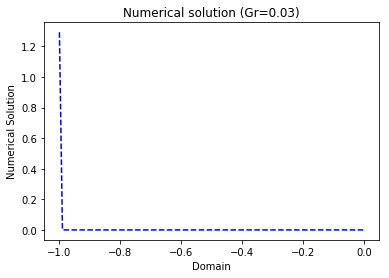

In [43]:
δ=1
Bi=-3
Gr=0.03

z, ω = CalcFirstEquation(δ, Bi, Gr)

plt.plot(z, ω, color='blue', markerfacecolor='blue', linestyle='dashed')
plt.title('Numerical solution (Gr={})'.format(Gr))
plt.xlabel('Domain')
plt.ylabel('Numerical Solution')
plt.show()

In [42]:
for i in range(0, len(z)):
    if ω[i] <= 0:
        print('z={}, ω={}'.format(z[i], ω[i]))

z=-1.0, ω=0.0
z=-0.98, ω=-2.6931097777800486e-06
z=-0.96, ω=-4.387432626978753e-06
z=-0.94, ω=-4.748096216438852e-06
z=-0.92, ω=-4.220689130666156e-06
z=-0.9, ω=-3.2575964148321166e-06
z=-0.88, ω=-2.1430705885778453e-06
z=-0.86, ω=-1.0265982360334277e-06
z=-0.38, ω=-2.6996326576976226e-07
z=-0.36, ω=-9.090711828631195e-07
z=-0.33999999999999997, ω=-1.5605149214807367e-06
z=-0.31999999999999995, ω=-2.219494058080109e-06
z=-0.29999999999999993, ω=-2.8812081570028764e-06
z=-0.28, ω=-3.5408567704933043e-06
z=-0.26, ω=-4.193639438773871e-06
z=-0.24, ω=-4.834755690045001e-06
z=-0.21999999999999997, ω=-5.459405040496162e-06
z=-0.19999999999999996, ω=-6.0627869942913216e-06
z=-0.17999999999999994, ω=-6.640101043526367e-06
z=-0.16000000000000003, ω=-7.1865466681921545e-06
z=-0.14, ω=-7.697323336097972e-06
z=-0.12, ω=-8.167630502793152e-06
z=-0.09999999999999998, ω=-8.592667611464106e-06
z=-0.07999999999999996, ω=-8.96763409284884e-06
z=-0.05999999999999994, ω=-9.287729365108455e-06
z=-0.0400000

In [21]:
for i in range(0, len(z)):
    print('z={}, ω={}'.format(z[i], ω[i]))

z=-1.0, ω=1.2931149284063068
z=-0.99, ω=-4.129889453180983e-06
z=-0.98, ω=-7.885081546960533e-06
z=-0.97, ω=-9.958833576776518e-06
z=-0.96, ω=-1.0784093643455407e-05
z=-0.95, ω=-1.089124955043344e-05
z=-0.94, ω=-1.0634608323948508e-05
z=-0.9299999999999999, ω=-1.0208400390212861e-05
z=-0.92, ω=-9.709344708685876e-06
z=-0.91, ω=-9.18296596943994e-06
z=-0.9, ω=-8.649903517756158e-06
z=-0.89, ω=-8.119254493725115e-06
z=-0.88, ω=-7.59492893808192e-06
z=-0.87, ω=-7.078558100744068e-06
z=-0.86, ω=-6.5707890930059334e-06
z=-0.85, ω=-6.071849644956884e-06
z=-0.84, ω=-5.581790675887259e-06
z=-0.83, ω=-5.1005892137895114e-06
z=-0.8200000000000001, ω=-4.628191632260278e-06
z=-0.81, ω=-4.164531666441676e-06
z=-0.8, ω=-3.7095378684954126e-06
z=-0.79, ω=-3.263136674861938e-06
z=-0.78, ω=-2.8252536618203266e-06
z=-0.77, ω=-2.3958140571915485e-06
z=-0.76, ω=-1.9747429480808047e-06
z=-0.75, ω=-1.5619653649321248e-06
z=-0.74, ω=-1.1574063154279954e-06
z=-0.73, ω=-7.609907981370006e-07
z=-0.72, ω=-3.7264

In [ ]:
CalcInitialConditions(δ=0.01, Bi=2, Gr=0.03, z=-1, ω=0)

1.3028923053984047

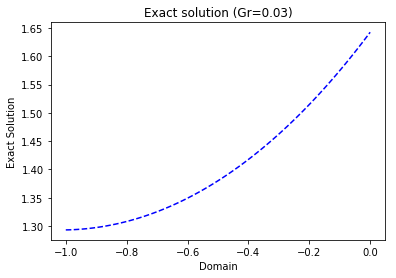

In [ ]:
w_i = lambda z, Bi, δ, Gr: CalcInitialConditions(z, Bi, δ, Gr, 0.5)
PrintExactSolution(w_i, Parameters(Bi=2, δ=0.01, Gr=0.03))